In [ ]:
#Preporcessing and Visualisation/Data_Preprocessing

#*Complex processing and Visualisation of the Imagery*

#**Chapter 3.2**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install basemap
!pip install cartopy
!pip install geopandas
!pip install harp-image-preprocess


In [ ]:
import numpy as np
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import sys
from netCDF4 import Dataset
from numpy import unravel_index
import pandas as pd
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from geopy.geocoders import Nominatim
import time
from pprint import pprint

In [ ]:
!ls /content/gdrive/MyDrive/Sent/May20-Aug21/L2__NO2___


## **Averaging over day**

In [ ]:
name = '/content/gdrive/MyDrive/Sent/Sep2021/L2__NO2___/S5P_OFFL_L2__NO2____20210903T115446_20210903T133616_20162_02_020200_20210905T052151.nc'
file = Dataset(name, 'r')
ds=file
ti = ds.time_reference
grp='PRODUCT'  
vlist = list(file[grp].variables.keys())
lat= ds.groups[grp].variables['latitude'][0][:][:]
lon= ds.groups[grp].variables['longitude'][0][:][:]


l= ds.groups[grp].variables['delta_time'][0][:][:]
vlist

In [ ]:
#the columns we are interested 
name_list = ['nitrogendioxide_tropospheric_column',
 'nitrogendioxide_tropospheric_column_precision',
 'nitrogendioxide_tropospheric_column_precision_kernel',
 'averaging_kernel',
 'air_mass_factor_troposphere',
 'air_mass_factor_total',
 'tm5_tropopause_layer_index',
 'tm5_constant_a',
 'tm5_constant_b', 
 'qa_value']

In [ ]:
len(lat[1])
lat.shape[0]*lat.shape[1]

1877850

##**Feature Extraction Stage**

Reference:
The model scrip was adopted from the following webpage:

https://appliedsciences.nasa.gov/join-mission/training/english/arset-high-resolution-no2-monitoring-space-tropomi 

In [ ]:
#Loops through all the NetCDF files 

fileList=open('/content/gdrive/MyDrive/Sent/May20-Aug21.txt','r')
all_data = []
for file_n in fileList: 
  file_n=file_n.strip()
  file = Dataset('/content/gdrive/MyDrive/Sent/May20-Aug21/L2__NO2___/'+file_n, 'r')
  ds=file
  grp='PRODUCT'   
  ti = ds.time_reference   #time
  lat= ds.groups[grp].variables['latitude'][0][:][:]
  lon= ds.groups[grp].variables['longitude'][0][:][:]
  df = pd.DataFrame()
  df['latitude'] = lat.ravel()
  df['longitute'] = lon.ravel()
  # new_day = [ti] * lat.shape[0]*lat.shape[1]
  # new_day = np.array(new_day)
  # df['date'] = new_day.ravel()
  scan_time= ds.groups[grp].variables['time_utc']
  year = np.zeros(lat.shape)
  mth = np.zeros(lat.shape)
  day = np.zeros(lat.shape)
  hr = np.zeros(lat.shape)
  import datetime as dt
  import pandas as pd
  for i in range(0,lat.shape[0]):
      t = scan_time[0][i].split('.')[0]
      t2 = dt.datetime.strptime(t,'%Y-%m-%dT%H:%M:%S')
      y = t2.year
      m = t2.month
      d = t2.day
      h = t2.hour
      year[i][:] = y
      mth[i][:] = m
      day[i][:] = d
      hr[i][:] = h

  df['Year'] = year.ravel()
  df['Month'] = mth.ravel()
  df['Day'] = day.ravel()
  df['Hour'] = hr.ravel()
  #df['nitrogendioxide_tropospheric_column'] = data.ravel()
  # SDS_NAME='nitrogendioxide_tropospheric_column'

  for i in range(0,len(name_list)):
            SDS_NAME=name_list[(i)] # The name of the sds to read
            #get current SDS data, or exit program if the SDS is not found in the file
            #try:
            sds=ds.groups[grp].variables[SDS_NAME]
            if len(sds.shape) == 3:
                #print(SDS_NAME,sds.shape)
                #get attributes for current SDS
                if 'qa' in SDS_NAME:
                    scale=sds.scale_factor
                else: scale = 1.0
                fv=sds._FillValue 
                data=sds[:].ravel()
                ata=data.astype(float)
                data=(data)*scale
                data[np.isnan(data)]=fv
                data[data==float(fv)]=np.nan
                df[SDS_NAME] = data
  
  
#bounding box berlin
#'boundingbox': ['52.3382448', '52.6755087', '13.088345', '13.7611609'],
#https://www.google.com/search?client=safari&rls=en&q=bounding+box+berlin&ie=UTF-8&oe=UTF-8

  df = df.dropna()
  #df = df.loc[(df['latitude'] >= 52.35900) & (df['latitude'] <= 52.85400) & (df['longitute'] >= 13.088345) & (df['longitute'] <= 13.7611609)]
  df = df.loc[(df['latitude'] >= 52.15) & (df['latitude'] <= 52.95) & (df['longitute'] >= 12.9) & (df['longitute'] <= 13.9)] 
  all_data.append(df)
final=pd.concat(all_data,ignore_index=True)

In [ ]:
final.shape

(140835, 13)

In [ ]:
final.head()

,latitude,longitute,Year,Month,Day,Hour,nitrogendioxide_tropospheric_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,air_mass_factor_troposphere,air_mass_factor_total,tm5_tropopause_layer_index,qa_value
0,52.157349,13.716069,2020.0,5.0,1.0,11.0,1.459978e-05,0.000018,0.000017,0.952377,1.804340,14.0,0.0074
1,52.192528,13.806399,2020.0,5.0,1.0,11.0,-6.227974e-06,0.000014,0.000014,0.951523,1.798625,14.0,0.0074
2,52.227226,13.895948,2020.0,5.0,1.0,11.0,5.757178e-07,0.000013,0.000013,0.918600,1.780306,14.0,0.0074
3,52.167213,13.589217,2020.0,5.0,1.0,11.0,1.580315e-05,0.000011,0.000011,1.077755,1.861350,14.0,0.0074
4,52.202911,13.680410,2020.0,5.0,1.0,11.0,1.687530e-05,0.000016,0.000015,1.005521,1.828623,14.0,0.0074


In [ ]:
#final.to_csv('/content/gdrive/MyDrive/Sent/May20-Aug21_data.csv', index=False) 

In [ ]:
final['Hour'].unique()

array([11., 13., 12., 10.])

In [ ]:
#df.to_csv('/content/gdrive/MyDrive/Sent/Feb22-Sep22_data', index=False) 

In [ ]:
final.shape

(118872, 12)

##**Read the file**

In [ ]:
fileList=open('/content/gdrive/MyDrive/Sent/Sept2021.txt','r')
for file_n in fileList: 
  file_n=file_n.strip()
  file = Dataset('/content/gdrive/MyDrive/Sent/Sep2021/L2__NO2___/'+file_n, 'r')
  print(file)

In [ ]:
app = Nominatim(user_agent="tutorial")
location = app.geocode("Germany, Berlin").raw
# print raw data
pprint(location)

{'boundingbox': ['52.3382448', '52.6755087', '13.088345', '13.7611609'],
 'class': 'boundary',
 'display_name': 'Berlin, Deutschland',
 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png',
 'importance': 0.8975390282491362,
 'lat': '52.5170365',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. '
            'https://osm.org/copyright',
 'lon': '13.3888599',
 'osm_id': 62422,
 'osm_type': 'relation',
 'place_id': 297499108,
 'type': 'administrative'}


In [ ]:
df['nitrogendioxide_tropospheric_column'].max()

0.00010850559

In [ ]:
df = df.dropna()

,Year,Month,Day,Hour,latitude,longitude,qa_value,nitrogendioxide_tropospheric_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,air_mass_factor_troposphere,air_mass_factor_total,tm5_tropopause_layer_index
111601,2021.0,9.0,3.0,12.0,-80.594292,-6.965050,0.0007,-5.447930e-06,0.000010,0.000009,10.840795,15.060045,20.0
111602,2021.0,9.0,3.0,12.0,-80.614792,-6.445107,0.0007,-2.600548e-06,0.000010,0.000010,10.866412,15.080253,20.0
111603,2021.0,9.0,3.0,12.0,-80.634285,-5.930222,0.0007,-1.922391e-09,0.000010,0.000010,10.856234,15.100107,20.0
112051,2021.0,9.0,3.0,12.0,-80.550713,-6.855190,0.0007,-2.207261e-06,0.000009,0.000009,10.820048,14.973653,20.0
112052,2021.0,9.0,3.0,12.0,-80.571037,-6.337364,0.0007,-8.031790e-07,0.000009,0.000009,10.833792,14.990416,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783803,2021.0,9.0,3.0,13.0,65.144745,-119.008179,0.0005,-9.257338e-05,0.000067,0.000064,1.555661,12.218963,16.0
1784251,2021.0,9.0,3.0,13.0,64.991348,-118.846741,0.0005,-5.827203e-05,0.000064,0.000063,1.564162,12.188481,16.0
1784252,2021.0,9.0,3.0,13.0,65.054802,-118.978302,0.0005,-7.818608e-05,0.000066,0.000064,1.557551,12.234278,16.0
1784253,2021.0,9.0,3.0,13.0,65.117287,-119.108696,0.0005,-6.341398e-05,0.000067,0.000065,1.550752,12.281730,16.0


In [ ]:
df.loc[(df['latitude'] >= 52.35900) & (df['latitude'] <= 52.85400)]

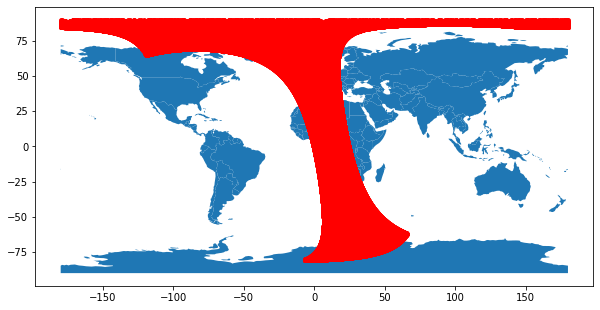

In [ ]:
#https://stackoverflow.com/questions/62649240/python-geopandas-module-object-not-callable

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);